In [122]:
import pandas as pd
from pathlib import Path
from fastai import *
from fastai.vision import *

Select subsample of the data as the data is too large.

In [123]:
train_df = pd.read_csv("train.csv")
train_df.groupby('target').size()

target
de    24360
en    24360
es    24360
mo        1
dtype: int64

In [124]:
train_df = train_df.drop(train_df[train_df["target"] == 'mo'].index)

The train size is too large. Let's choose random sample of 10500 images stratified by the target class.

In [125]:
new_train_df = train_df.groupby('target').apply(lambda x: x.sample(n=3500)).reset_index(drop = True)

In [126]:
new_train_df["target"].value_counts()

de    3500
en    3500
es    3500
Name: target, dtype: int64

Save new train dataframe as csv

In [127]:
new_train_df.to_csv("sample_train.csv")

In [176]:
new_train_df = pd.read_csv("sample_train.csv")
image_train_path = Path("data/mono_images/train")
fnames = [image_train_path / path for path in list(new_train_df["fnames"])]
labels = new_train_df["target"]
path = Path("data")
bs=32
data = ImageDataBunch.from_lists(path, fnames, labels, ds_tfms=get_transforms(), bs=bs)
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (8400 items)
x: ImageList
Image (3, 40, 862),Image (3, 40, 862),Image (3, 40, 862),Image (3, 40, 862),Image (3, 40, 862)
y: CategoryList
de,de,de,de,de
Path: data;

Valid: LabelList (2100 items)
x: ImageList
Image (3, 40, 862),Image (3, 40, 862),Image (3, 40, 862),Image (3, 40, 862),Image (3, 40, 862)
y: CategoryList
de,en,de,en,de
Path: data;

Test: None

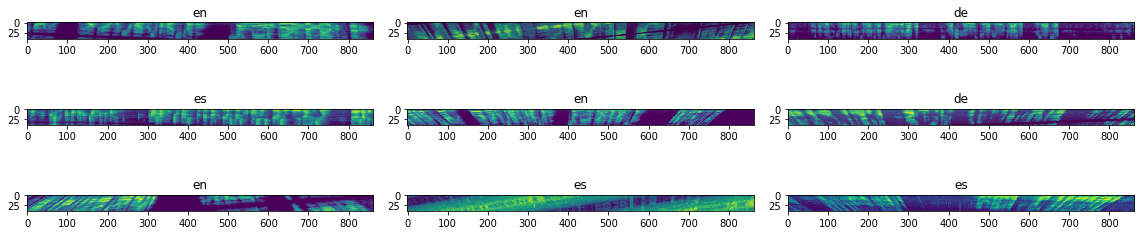

In [177]:
data.show_batch(3, figsize=(16,4), hide_axis=False)

## Stage 1

I'll be using resnet152 architecture for the model as it's proven to do great job on image classification. For hyperparameters tuning, only learning rate and number of epochs will only be tuned.

In [178]:
learn = cnn_learner(data, models.resnet152, metrics=accuracy)

Using fastai learning rate finder to get the best learning rate. Learning rate is chosen at the point a bit before the minimum where the loss still improves.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


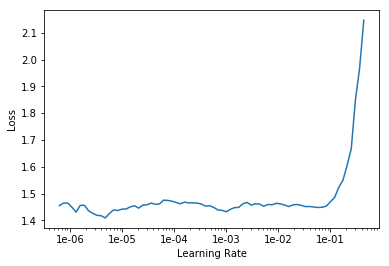

In [179]:
learn.lr_find()
learn.recorder.plot()

In [180]:
lr = 1e-2

In [181]:
learn.fit_one_cycle(4, max_lr = lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.890004,1.803385,0.544762,02:39
1,0.665362,1.941375,0.530000,02:38
2,0.510311,0.244607,0.901429,02:38
3,0.395119,0.139218,0.945714,02:38


In [182]:
learn.fit_one_cycle(7, max_lr = lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.440707,0.314787,0.870000,02:38
1,0.609650,1.091424,0.600000,02:38
2,0.560680,0.459538,0.824762,02:38
3,0.490370,0.287408,0.879048,02:38
4,0.411491,0.153262,0.940952,02:38
5,0.339404,0.116897,0.957619,02:38
6,0.294495,0.092555,0.966667,02:38


In [183]:
learn.save("resnet152-stage-1")

## Stage 2

Unfreeze all layers to fine tune earlier layers. Using batch size 16 to avoid running out of memory.

In [184]:
data.batch_size = 16
learn = cnn_learner(data, models.resnet152, metrics=accuracy)
learn.load("resnet152-stage-1")
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


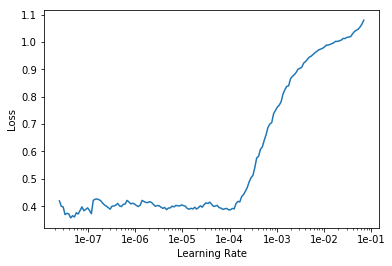

In [185]:
learn.lr_find(start_lr=1e-8, end_lr=9e-1, num_it=200)
learn.recorder.plot()

In [186]:
data.batch_size = 16

lr = 1e-4

learn.fit_one_cycle(10, lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.448980,0.200250,0.940476,03:52
1,0.499218,0.267564,0.920000,03:51
2,0.559199,1.403649,0.762381,03:51
3,0.455346,0.400582,0.897619,03:51
4,0.399199,0.452905,0.885238,03:51
5,0.345873,0.174936,0.960952,03:50
6,0.315858,0.102773,0.967143,03:51
7,0.263722,0.125227,0.972381,03:51
8,0.248624,0.062990,0.986667,03:51
9,0.242583,0.066793,0.985714,03:51


In [187]:
learn.save("stage-2-no-diff")

In [188]:
learn = cnn_learner(data, models.resnet152, metrics=accuracy)
learn.load("resnet152-stage-1")
learn.unfreeze()

lr = 1e-4
lrs = np.array([lr/9,lr/6,lr])
learn.fit_one_cycle(12, lrs)

epoch,train_loss,valid_loss,accuracy,time
0,0.353492,0.101941,0.960476,03:51
1,0.417849,0.275525,0.961905,03:51
2,0.351156,0.136299,0.950476,03:50
3,0.358667,0.256225,0.950952,03:50
4,0.346215,0.113299,0.964286,03:51
5,0.310933,0.149906,0.953809,03:51
6,0.293308,0.110970,0.962381,03:51
7,0.292486,0.142903,0.967143,03:51
8,0.269654,0.124964,0.974286,03:51
9,0.237833,0.070192,0.980476,03:51


In [190]:
learn.save("stage-2-diff")

## Stage 3

In [191]:
learn = cnn_learner(data, models.resnet152, metrics=accuracy)
learn.load("stage-2-diff")
learn.freeze()

In [192]:
lr = 1e-4
learn.fit_one_cycle(8, lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.249305,0.775522,0.952381,03:03
1,0.261897,0.058914,0.982857,03:02
2,0.218793,0.056141,0.984762,03:02
3,0.242057,0.081157,0.980476,03:01
4,0.259871,0.071374,0.983810,03:01
5,0.235882,0.055914,0.983333,03:01
6,0.226227,0.079295,0.980952,03:01
7,0.246964,0.057705,0.986190,03:01


In [194]:
learn.save("stage3")

## Testing

In [94]:
test_df = pd.read_csv("test.csv")
test_df.head()

,Unnamed: 0,fnames,target,gender,transformation,fragment
0,0,de_m_923551d571cc437382d0294dda2dd0aa.fragment...,de,m,NaN,fragment74
1,1,en_f_67a0cba10d171b24039a79faa1d4d603.fragment...,en,f,NaN,fragment6
2,2,es_m_08111ce8d6a7ebc6cd2c27e62a3d98f0.fragment...,es,m,NaN,fragment22
3,3,de_f_63f5b79c76cf5a1a4bbd1c40f54b166e.fragment...,de,f,NaN,fragment48
4,4,es_m_08111ce8d6a7ebc6cd2c27e62a3d98f0.fragment...,es,m,NaN,fragment83


In [95]:
path = Path("data/mono_images/test")

data.add_test(ImageList.from_df(test_df[["fnames", "target"]], path))

In [96]:
data

ImageDataBunch;

Train: LabelList (8400 items)
x: ImageList
Image (3, 40, 862),Image (3, 40, 862),Image (3, 40, 862),Image (3, 40, 862),Image (3, 40, 862)
y: CategoryList
de,de,de,de,de
Path: data/mono_images/train;

Valid: LabelList (2100 items)
x: ImageList
Image (3, 40, 862),Image (3, 40, 862),Image (3, 40, 862),Image (3, 40, 862),Image (3, 40, 862)
y: CategoryList
en,de,de,es,en
Path: data/mono_images/train;

Test: LabelList (540 items)
x: ImageList
Image (3, 40, 862),Image (3, 40, 862),Image (3, 40, 862),Image (3, 40, 862),Image (3, 40, 862)
y: EmptyLabelList
,,,,
Path: data/mono_images/train

In [116]:
y_true = test_df["target"].map({'de': 0, "en": 1, "es": 2})
y_true = np.array(y_true)
y_true = torch.from_numpy(y_true)

In [118]:
log_testpreds, _ = learn.get_preds(ds_type=DatasetType.Test)
print(f"accuracy: {accuracy(log_testpreds, y_true)}")

accuracy: 0.9462962746620178


The accuracy on test set is 94.63%. Let's look at the classification report to check our precision, recall and f1 score.

In [91]:
from sklearn.metrics import classification_report

In [93]:
print(classification_report(targets, np.argmax(preds, axis=1)))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93       180
           1       0.99      0.87      0.92       180
           2       0.99      0.98      0.99       180

   micro avg       0.95      0.95      0.95       540
   macro avg       0.95      0.95      0.95       540
weighted avg       0.95      0.95      0.95       540

